# Bias Buccaneers Image Recognition Challenge - Solution

In [1]:
#import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


## Prepare the data

### Data Pre-processing

In [3]:
dataset_path = "../input/bias-buccaneers/"
train_df = pd.read_csv(f"{dataset_path}train/labels.csv")
test_df = pd.read_csv(f"{dataset_path}test/labels.csv")

In [4]:
print(f"Number of Training samples: {len(train_df)}")
print(f"Number of Testing samples: {len(test_df)}")

Number of Training samples: 12283
Number of Testing samples: 3000


In [5]:
categories = train_df.columns[1:].tolist()
print(categories)

['skin_tone', 'gender', 'age']


In [6]:
train_df.isnull().sum()

name            0
skin_tone    3730
gender       3730
age          3730
dtype: int64

There are around 3730 samples in the training set which are unlabeled.

In [7]:
train_df_labeled = train_df[train_df["skin_tone"].notna()].copy(deep=True) # take only labeled data
print(f"Number of labeled samples in the training set: {len(train_df_labeled)}")

Number of labeled samples in the training set: 8553


In [8]:
#Modify the index values of the df
train_df_labeled.reset_index(drop=True, inplace=True)

Now we need to encode the labels into an integer such that we can use PyTorch's CrossEntropyLoss.

In [9]:
print(f"Labels for Skin tone: {train_df_labeled['skin_tone'].unique().tolist()}, Count: {len(train_df_labeled['skin_tone'].unique())}")
print(f"Labels for Gender: {train_df_labeled['gender'].unique().tolist()}, Count: {len(train_df_labeled['gender'].unique())}")
print(f"Labels for Age: {train_df_labeled['age'].unique().tolist()}, Count: {len(train_df_labeled['age'].unique())}")

Labels for Skin tone: ['monk_1', 'monk_6', 'monk_3', 'monk_2', 'monk_8', 'monk_4', 'monk_5', 'monk_9', 'monk_7', 'monk_10'], Count: 10
Labels for Gender: ['female', 'male'], Count: 2
Labels for Age: ['18_30', '0_17', '31_60', '61_100'], Count: 4


In [10]:
skin_tone_labels = [f"monk_{i}" for i in range(1,11)]
gender_labels = ["male", "female"]
age_labels = ["0_17", "18_30", "31_60", "61_100"]

In [11]:
#encode train samples
train_df_labeled['skin_tone'].replace(skin_tone_labels, list(range(len(skin_tone_labels))), inplace=True)
train_df_labeled['gender'].replace(gender_labels, list(range(len(gender_labels))), inplace=True)
train_df_labeled['age'].replace(age_labels, list(range(len(age_labels))), inplace=True)

In [12]:
#encode test samples
test_df['skin_tone'].replace(skin_tone_labels, list(range(len(skin_tone_labels))), inplace=True)
test_df['gender'].replace(gender_labels, list(range(len(gender_labels))), inplace=True)
test_df['age'].replace(age_labels, list(range(len(age_labels))), inplace=True)

### Distribution of class labels

In [13]:
#train_df_labeled.skin_tone.hist()
#plt.xticks(list(range(10)))
#plt.grid(False)
#plt.show() 

### Plotting images

skin tone: monk_3
gender: female
age: 18_30


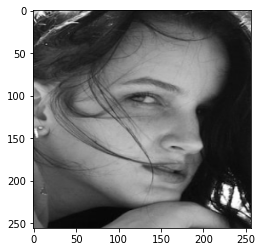

In [14]:
sample_img_id = 123
sample_img = Image.open(f"{dataset_path}train/{train_df_labeled['name'][sample_img_id]}")
plt.imshow(sample_img)
print(f"skin tone: {skin_tone_labels[train_df_labeled['skin_tone'][sample_img_id]]}")
print(f"gender: {gender_labels[train_df_labeled['gender'][sample_img_id]]}")
print(f"age: {age_labels[train_df_labeled['age'][sample_img_id]]}")

### Building the DataLoader

In [15]:
class ImageDataset(Dataset):
    def __init__(self, df, data_path, image_transform=None):
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = Image.open(f"{self.data_path}{self.df['name'][index]}")
        if self.image_transform:
            img = self.image_transform(img)
        #we need to provide labels for skin_tone, gender, age
        labels = (self.df['skin_tone'][index], self.df['gender'][index], self.df['age'][index])
        return img, labels

In [16]:
image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
train_dataset = ImageDataset(train_df_labeled, f"{dataset_path}train/", image_transform)

In [17]:
#for testing purposes
#img_batch = next(iter(train_loader))

In [18]:
grayscale_indices = []
for i in range(len(train_dataset)):
    if(train_dataset[i][0].shape[0] == 3):
        continue
    else:
        grayscale_indices.append(i)
print(len(grayscale_indices))

5


Since there are only 5 grayscale images. It is better to remove them from the dataframe

In [19]:
train_dataset.df.drop(labels=grayscale_indices, axis=0, inplace=True)
train_dataset.df.reset_index(drop=True, inplace=True)
train_dataset.image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [20]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

## Build the model

In [21]:
class ClassifierModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Sequential(nn.ReLU(), nn.Linear(1000, 512), nn.ReLU(), nn.Linear(512, num_classes))
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

Create separate instantiations of ClassifierModel for classifying skin tone, gender, age.

In [22]:
skintone_classifier = ClassifierModel(num_classes=10).to(device)
gender_classifier = ClassifierModel(num_classes=2).to(device)
age_classifier = ClassifierModel(num_classes=4).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Helper functions

In [23]:
def train(dataloader, model, loss_fn, optimizer, class_index:int, num_epochs:int = 100):
    model.train()
    for epoch in range(1,num_epochs+1):
        total = 0
        correct = 0
        running_loss = 0
        for imgs, labels in dataloader:
            labels = labels[class_index]
            output = model(imgs.to(device))
            loss = loss_fn(output, labels.to(device))
                   
            running_loss += loss.item()
            total        += labels.size(0)
            predictions   = output.argmax(dim=1).cpu().detach() 
            correct      += (predictions == labels.cpu().detach()).sum().item() 
        
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
             
        avg_loss = running_loss/len(dataloader) # Average loss for a single batch
        print(f'Epoch {epoch}/{num_epochs} - loss: {avg_loss:.2f} - accuracy: {correct/total:.2f}')

In [24]:
def make_predictions(dataloader, model):
    model.eval()
    predicted_labels = []
    with torch.no_grad():
        for imgs, _ in dataloader:
            output = model(imgs.to(device))
            preds = output.argmax(dim=1).cpu().detach().tolist()
            predicted_labels.extend(preds)
    return predicted_labels

## Train the model

Train all the classifier models. Before doing so, the classes for each category is unbalanced, so we need to calcualte the class weights.

In [25]:
from sklearn.utils import class_weight

In [26]:
#skintone classification
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array(range(len(skin_tone_labels))), y=train_df_labeled['skin_tone'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights
optimizer = torch.optim.SGD(skintone_classifier.parameters(), lr=0.01, momentum=0.9)
train(train_loader, skintone_classifier, loss_fn, optimizer, class_index=0, num_epochs=50)

Epoch 1/50 - loss: 2.18 - accuracy: 0.14
Epoch 2/50 - loss: 1.84 - accuracy: 0.23
Epoch 3/50 - loss: 1.57 - accuracy: 0.31
Epoch 4/50 - loss: 1.28 - accuracy: 0.39
Epoch 5/50 - loss: 0.99 - accuracy: 0.50
Epoch 6/50 - loss: 0.72 - accuracy: 0.61
Epoch 7/50 - loss: 0.50 - accuracy: 0.71
Epoch 8/50 - loss: 0.30 - accuracy: 0.83
Epoch 9/50 - loss: 0.18 - accuracy: 0.91
Epoch 10/50 - loss: 0.08 - accuracy: 0.97
Epoch 11/50 - loss: 0.03 - accuracy: 0.99
Epoch 12/50 - loss: 0.01 - accuracy: 1.00
Epoch 13/50 - loss: 0.00 - accuracy: 1.00
Epoch 14/50 - loss: 0.00 - accuracy: 1.00
Epoch 15/50 - loss: 0.00 - accuracy: 1.00
Epoch 16/50 - loss: 0.00 - accuracy: 1.00
Epoch 17/50 - loss: 0.00 - accuracy: 1.00
Epoch 18/50 - loss: 0.00 - accuracy: 1.00
Epoch 19/50 - loss: 0.00 - accuracy: 1.00
Epoch 20/50 - loss: 0.00 - accuracy: 1.00
Epoch 21/50 - loss: 0.00 - accuracy: 1.00
Epoch 22/50 - loss: 0.00 - accuracy: 1.00
Epoch 23/50 - loss: 0.00 - accuracy: 1.00
Epoch 24/50 - loss: 0.00 - accuracy: 1.00
E

In [27]:
#gender classification
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array(range(len(gender_labels))), y=train_df_labeled['gender'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
loss_fn   = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(gender_classifier.parameters(), lr=0.01, momentum=0.9)
train(train_loader, gender_classifier, loss_fn, optimizer, class_index=1, num_epochs=50)

Epoch 1/50 - loss: 0.57 - accuracy: 0.66
Epoch 2/50 - loss: 0.38 - accuracy: 0.80
Epoch 3/50 - loss: 0.26 - accuracy: 0.88
Epoch 4/50 - loss: 0.15 - accuracy: 0.94
Epoch 5/50 - loss: 0.06 - accuracy: 0.98
Epoch 6/50 - loss: 0.05 - accuracy: 0.98
Epoch 7/50 - loss: 0.08 - accuracy: 0.97
Epoch 8/50 - loss: 0.07 - accuracy: 0.97
Epoch 9/50 - loss: 0.03 - accuracy: 0.99
Epoch 10/50 - loss: 0.02 - accuracy: 0.99
Epoch 11/50 - loss: 0.02 - accuracy: 0.99
Epoch 12/50 - loss: 0.02 - accuracy: 0.99
Epoch 13/50 - loss: 0.02 - accuracy: 0.99
Epoch 14/50 - loss: 0.02 - accuracy: 0.99
Epoch 15/50 - loss: 0.02 - accuracy: 0.99
Epoch 16/50 - loss: 0.01 - accuracy: 1.00
Epoch 17/50 - loss: 0.00 - accuracy: 1.00
Epoch 18/50 - loss: 0.00 - accuracy: 1.00
Epoch 19/50 - loss: 0.00 - accuracy: 1.00
Epoch 20/50 - loss: 0.00 - accuracy: 1.00
Epoch 21/50 - loss: 0.00 - accuracy: 1.00
Epoch 22/50 - loss: 0.00 - accuracy: 1.00
Epoch 23/50 - loss: 0.00 - accuracy: 1.00
Epoch 24/50 - loss: 0.00 - accuracy: 1.00
E

In [28]:
#age classification
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.array(range(len(age_labels))), y=train_df_labeled['age'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights
optimizer = torch.optim.SGD(age_classifier.parameters(), lr=0.01, momentum=0.9)
train(train_loader, age_classifier, loss_fn, optimizer, class_index=2, num_epochs=50)

Epoch 1/50 - loss: 1.22 - accuracy: 0.40
Epoch 2/50 - loss: 0.91 - accuracy: 0.50
Epoch 3/50 - loss: 0.71 - accuracy: 0.59
Epoch 4/50 - loss: 0.59 - accuracy: 0.65
Epoch 5/50 - loss: 0.46 - accuracy: 0.72
Epoch 6/50 - loss: 0.29 - accuracy: 0.83
Epoch 7/50 - loss: 0.17 - accuracy: 0.91
Epoch 8/50 - loss: 0.08 - accuracy: 0.97
Epoch 9/50 - loss: 0.19 - accuracy: 0.91
Epoch 10/50 - loss: 0.32 - accuracy: 0.84
Epoch 11/50 - loss: 0.21 - accuracy: 0.90
Epoch 12/50 - loss: 0.07 - accuracy: 0.97
Epoch 13/50 - loss: 0.02 - accuracy: 0.99
Epoch 14/50 - loss: 0.01 - accuracy: 1.00
Epoch 15/50 - loss: 0.00 - accuracy: 1.00
Epoch 16/50 - loss: 0.00 - accuracy: 1.00
Epoch 17/50 - loss: 0.00 - accuracy: 1.00
Epoch 18/50 - loss: 0.00 - accuracy: 1.00
Epoch 19/50 - loss: 0.00 - accuracy: 1.00
Epoch 20/50 - loss: 0.00 - accuracy: 1.00
Epoch 21/50 - loss: 0.00 - accuracy: 1.00
Epoch 22/50 - loss: 0.00 - accuracy: 1.00
Epoch 23/50 - loss: 0.00 - accuracy: 1.00
Epoch 24/50 - loss: 0.00 - accuracy: 1.00
E

In [29]:
#save the models
import os
os.mkdir("saved models")
torch.save(skintone_classifier,"./saved models/skintone_classifier.pt")
torch.save(gender_classifier,"./saved models/gender_classifier.pt")
torch.save(age_classifier,"./saved models/age_classifier.pt")

## Make Predictions on Test data

In [30]:
#prepare the dataloader for test data
test_data = ImageDataset(test_df, f"{dataset_path}test/", image_transform)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [31]:
skintone_predictions = make_predictions(test_loader, skintone_classifier)
gender_predictions = make_predictions(test_loader, gender_classifier)
age_predictions = make_predictions(test_loader, age_classifier)

In [32]:
predictions = [skintone_predictions, gender_predictions, age_predictions]

## Prepare Submission

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [34]:
# calculate accuracy
acc = {}
for i in range(3):
    icat = categories[i]
    iacc = accuracy_score(test_df[icat], predictions[i])
    acc[icat] = iacc

# calculate disparity
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)

disp = {}
for i in range(3):
    icat = categories[i]
    idisp = disparity_score(test_df[icat], predictions[i])
    disp[icat] = idisp
disp

results = {'accuracy': acc, 'disparity': disp}
results

{'accuracy': {'skin_tone': 0.253, 'gender': 0.8146666666666667, 'age': 0.598},
 'disparity': {'skin_tone': 0.36016260162601627,
  'gender': 0.1818600271994978,
  'age': 0.5287647340141222}}

In [35]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

title = 'Test Submission'
    
submission = {
    'submission_name': title,
    'score': getScore(results),
    'metrics': results
}
submission

{'submission_name': 'Test Submission',
 'score': 5.570905798768945,
 'metrics': {'accuracy': {'skin_tone': 0.253,
   'gender': 0.8146666666666667,
   'age': 0.598},
  'disparity': {'skin_tone': 0.36016260162601627,
   'gender': 0.1818600271994978,
   'age': 0.5287647340141222}}}

In [36]:
import json
with open("balaji_submission.json", "w") as f:
    json.dump(submission, f, indent=4)